In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'simple_white'

## Load data

In [2]:
df = pd.read_csv('students_activity.csv')

In [3]:
df[df.module != 'pre-A1'].sample(5)

user_id        date module  lesson_num
16252       199  2022-03-27     A1          38
36920       477  2024-01-14     A1          84
45171       605  2023-12-24     A1          60
132059     2084  2023-11-12     A1          23
28628       360  2023-09-03     A1          68

### Modelling demand from new customers

In [4]:
new_users_df = df.groupby('user_id', as_index = False).date.min().rename(columns = {'date': 'cohort'})
new_users_stats_df = new_users_df.groupby('cohort')[['user_id']].count().rename(columns = {'user_id': 'new_users'})

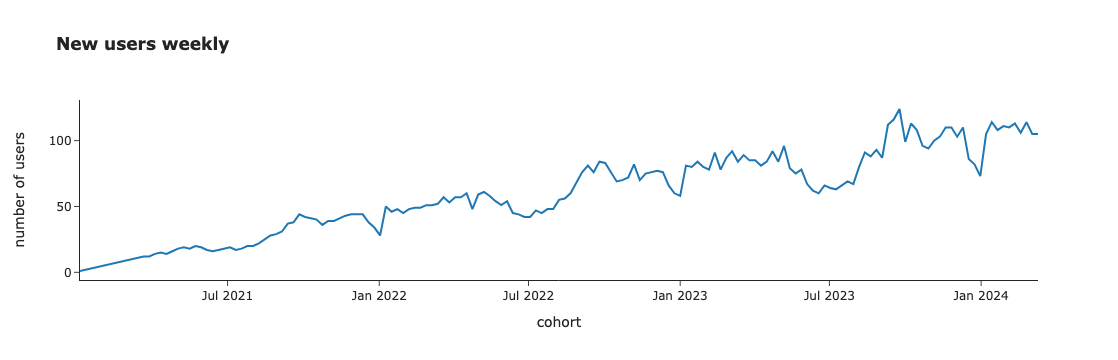

In [5]:
fig = px.line(
    new_users_stats_df,
    title = '<b>New users weekly</b>',
    labels = {'value': 'number of users'}
)
fig.update_layout(showlegend = False)

In [6]:
# ! pip install prophet

In [7]:
pred_new_users_df = new_users_stats_df.copy().reset_index()
pred_new_users_df = pred_new_users_df.rename(columns = {'new_users': 'y', 'cohort': 'ds'})
pred_new_users_df.ds = pd.to_datetime(pred_new_users_df.ds)
pred_new_users_df['cap'] = 100

In [10]:
from prophet import Prophet
m = Prophet(growth='logistic')
m.fit(pred_new_users_df)

22:34:15 - cmdstanpy - INFO - Chain [1] start processing
22:34:15 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.precision', 2)

In [12]:
future = m.make_future_dataframe(periods= 52, freq = 'W')
future['cap'] = 100
forecast_df = m.predict(future)
forecast_df.tail()[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds    yhat  yhat_lower  yhat_upper
214 2025-02-09  101.60       93.12      110.33
215 2025-02-16  103.38       94.72      111.91
216 2025-02-23  104.62       95.49      113.45
217 2025-03-02  103.97       95.58      112.14
218 2025-03-09  102.45       93.33      111.07

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



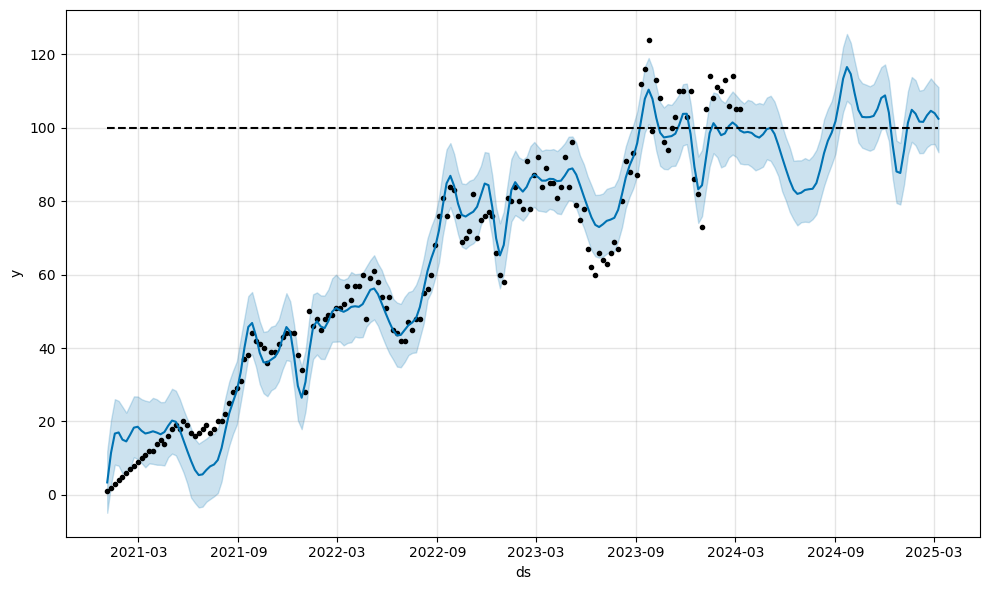

In [13]:
# from prophet.plot import plot_plotly, plot_components_plotly
m.plot(forecast_df);

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



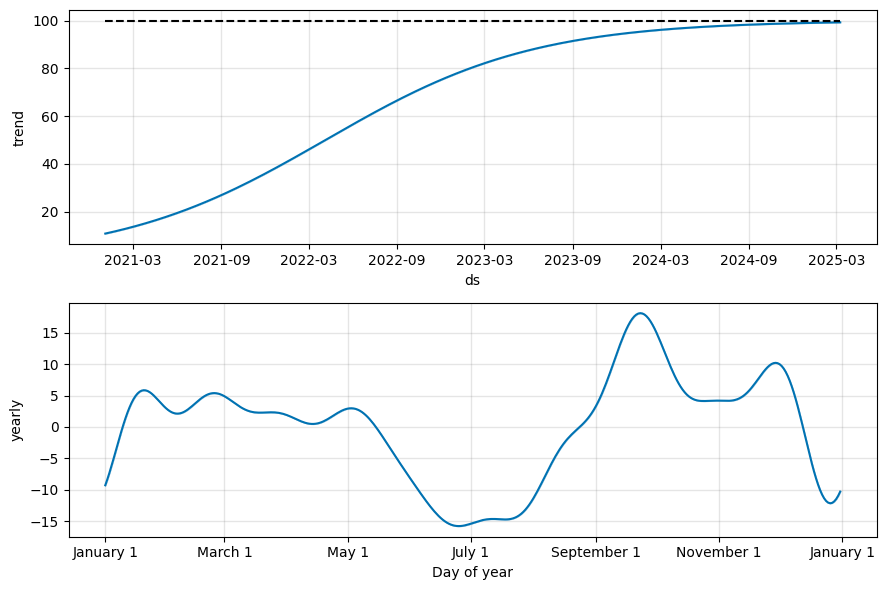

In [14]:
m.plot_components(forecast_df);

In [15]:
forecast_df = forecast_df[['ds', 'yhat']].rename(columns = {'ds': 'cohort', 'yhat': 'new_users_model'})

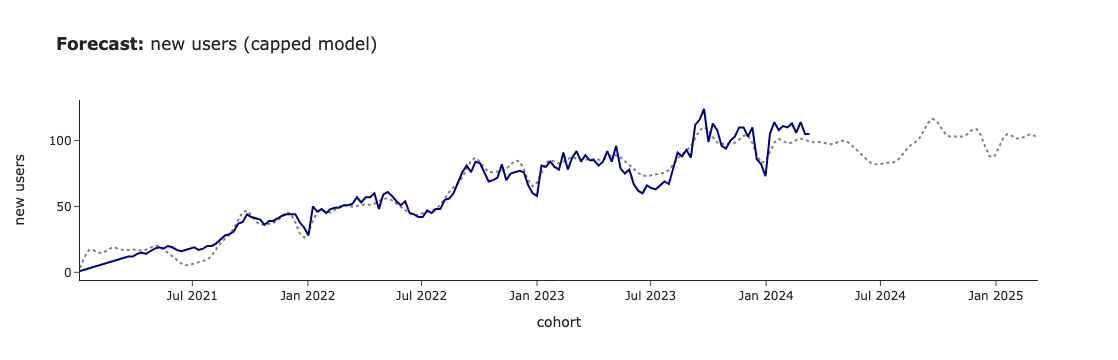

In [16]:
forecast_df = forecast_df.set_index('cohort').join(new_users_stats_df, how = 'outer')
    
fig = px.line(forecast_df, 
    title = '<b>Forecast:</b> new users (capped model)',
    labels = {'value': 'new users'},
    color_discrete_map = {'new_users': 'navy', 'new_users_model': 'gray'}
)
fig.update_traces(mode='lines', line=dict(dash='dot'), selector=dict(name='new_users_model'))
fig.update_layout(showlegend = False)
fig.show()

In [17]:
from prophet import Prophet

def make_prediction(df, param, param_name = '', periods = 52):
    date_param = df.index.name
    df.index = pd.to_datetime(df.index)
    
    train_df = df.reset_index().rename(columns = {date_param: 'ds', param: 'y'})

    m = Prophet()
    m.fit(train_df)

    future = m.make_future_dataframe(periods=periods, freq = 'W')
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']].rename(columns = {'ds': date_param, 'yhat': param + '_model'})

    forecast = forecast.set_index(date_param).join(df, how = 'outer')
    
    fig = px.line(forecast, 
        title = '<b>Forecast:</b> ' + (param if param_name == '' else param_name),
        labels = {'value': param if param_name == '' else param_name},
        color_discrete_map = {param: 'navy', param + '_model': 'gray'}
    )
    fig.update_traces(mode='lines', line=dict(dash='dot'), selector=dict(name=param + '_model'))
    fig.update_layout(showlegend = False)
    fig.show()

    return forecast

22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing


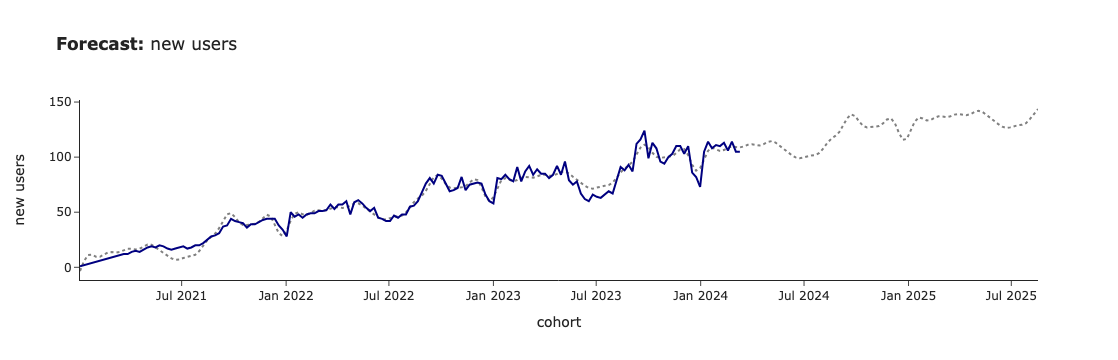

In [18]:
new_forecast_df = make_prediction(new_users_stats_df, 'new_users', 'new users', periods = 75)

### Modelling demand from existing users

In [19]:
model_existing_users = df[df.date < '2023-04-02'].user_id.unique()
raw_existing_df = df[df.user_id.isin(model_existing_users)]

In [20]:
existing_model_df = raw_existing_df[raw_existing_df.date >= '2023-04-02'].groupby('user_id', as_index = False).date.min().groupby('date', as_index = False).user_id.count()\
    .rename(columns = {'user_id': 'existing_users'})

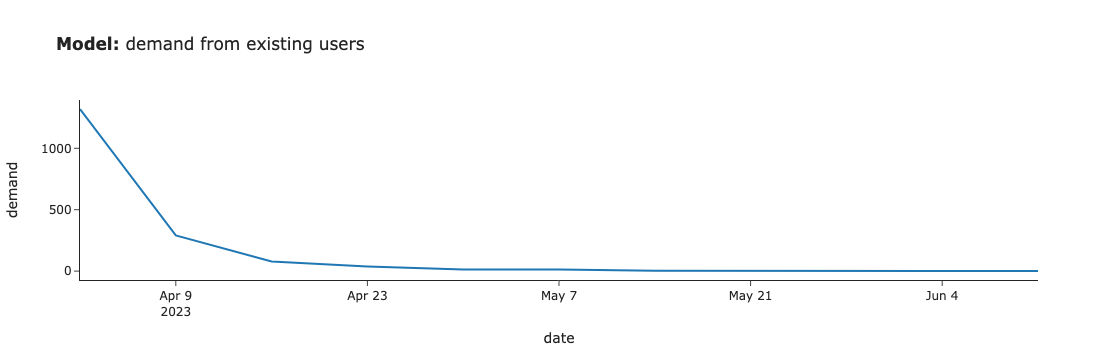

In [21]:
fig = px.line(existing_model_df.set_index('date'), 
             title = '<b>Model:</b> demand from existing users',
             labels = {'value': 'demand'})
fig.update_layout(showlegend = False)

In [22]:
active_users_df = df.groupby('date')[['user_id']].nunique()\
    .rename(columns = {'user_id': 'active_users'})

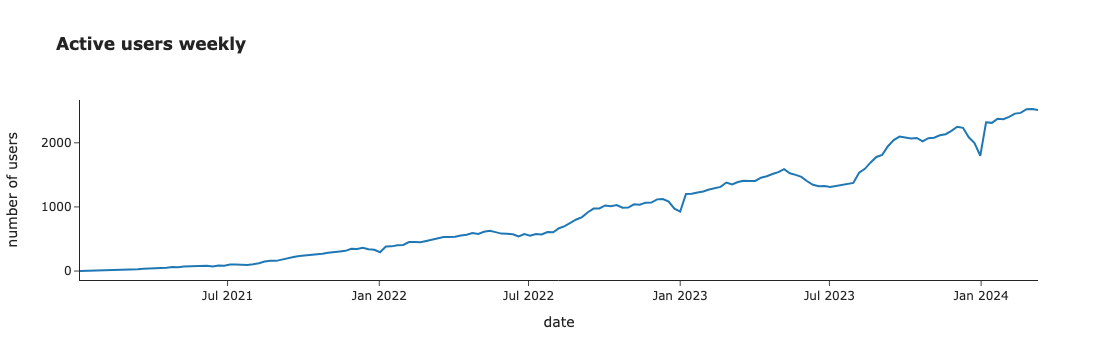

In [23]:
fig = px.line(
    active_users_df,
    title = '<b>Active users weekly</b>',
    labels = {'value': 'number of users'}
)
fig.update_layout(showlegend = False)

22:34:20 - cmdstanpy - INFO - Chain [1] start processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing


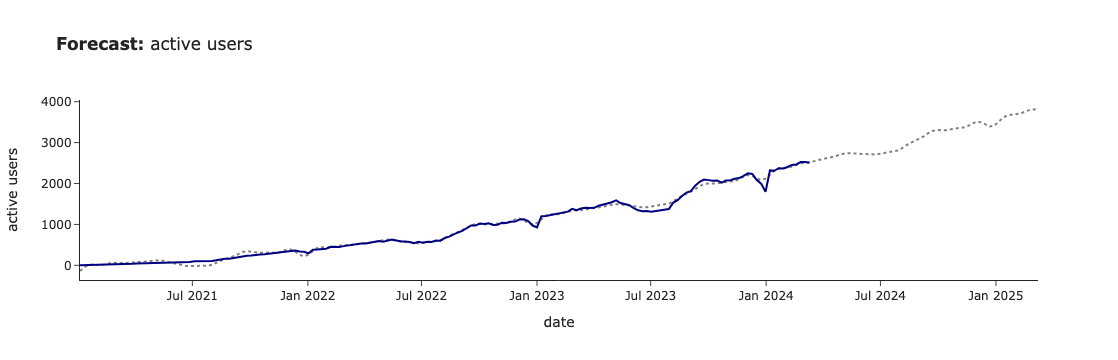

In [24]:
active_forecast_df = make_prediction(active_users_df, 'active_users', 'active users')

In [25]:
active_forecast_df['active_user_prev_year'] = active_forecast_df.active_users.shift(52)
active_forecast_df['yoy'] = active_forecast_df.active_users_model/active_forecast_df.active_user_prev_year

In [26]:
active_forecast_df.loc['2024-03-31':].head(10).mean()

active_users_model       2689.08
active_users                 NaN
active_user_prev_year    1487.80
yoy                         1.81
dtype: float64

In [27]:
active_forecast_df.loc['2024-03-31':].head(10)

active_users_model  active_users  active_user_prev_year   yoy
date                                                                     
2024-03-31             2598.00           NaN                 1405.0  1.85
2024-04-07             2615.03           NaN                 1456.0  1.80
2024-04-14             2635.92           NaN                 1478.0  1.78
2024-04-21             2670.09           NaN                 1513.0  1.76
2024-04-28             2709.34           NaN                 1543.0  1.76
2024-05-05             2735.71           NaN                 1590.0  1.72
2024-05-12             2741.38           NaN                 1524.0  1.80
2024-05-19             2734.91           NaN                 1500.0  1.82
2024-05-26             2728.01           NaN                 1469.0  1.86
2024-06-02             2722.42           NaN                 1400.0  1.94

In [28]:
existing_model_df = existing_model_df.rename(columns = {'date': 'model_date', 'existing_users': 'model_existing_users'})

In [29]:
import datetime
existing_model_df['date'] = existing_model_df.model_date.map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') + datetime.timedelta(364))

In [30]:
existing_model_df = existing_model_df.set_index('date').join(active_forecast_df[['yoy']])

In [31]:
existing_model_df['existing_users'] = list(map(
    lambda x, y: int(round(x*y)),
    existing_model_df.model_existing_users,
    existing_model_df.yoy
))

In [32]:
existing_model_df

model_date  model_existing_users   yoy  existing_users
date                                                              
2024-03-31  2023-04-02                  1320  1.85            2441
2024-04-07  2023-04-09                   291  1.80             523
2024-04-14  2023-04-16                    79  1.78             141
2024-04-21  2023-04-23                    38  1.76              67
2024-04-28  2023-04-30                    14  1.76              25
2024-05-05  2023-05-07                    14  1.72              24
2024-05-12  2023-05-14                     4  1.80               7
2024-05-19  2023-05-21                     1  1.82               2
2024-05-26  2023-05-28                     2  1.86               4
2024-06-02  2023-06-04                     1  1.94               2
2024-06-09  2023-06-11                     2  2.02               4

In [33]:
existing_model_df = existing_model_df.reset_index()[['date', 'existing_users']].rename(columns = {'existing_users': 'users'})
existing_model_df['segment'] = 'existing'

In [34]:
existing_model_df

date  users   segment
0  2024-03-31   2441  existing
1  2024-04-07    523  existing
2  2024-04-14    141  existing
3  2024-04-21     67  existing
4  2024-04-28     25  existing
5  2024-05-05     24  existing
6  2024-05-12      7  existing
7  2024-05-19      2  existing
8  2024-05-26      4  existing
9  2024-06-02      2  existing
10 2024-06-09      4  existing

In [35]:
new_model_df = new_forecast_df.reset_index()[['cohort', 'new_users_model']].rename(columns = {'cohort': 'date', 'new_users_model': 'users'})
new_model_df = new_model_df[(new_model_df.date >= '2024-03-31') & (new_model_df.date < '2025-04-07')]
new_model_df['users'] = new_model_df.users.map(lambda x: int(round(x)))
new_model_df['segment'] = 'new'

In [36]:
demand_model_df = pd.concat([existing_model_df, new_model_df])

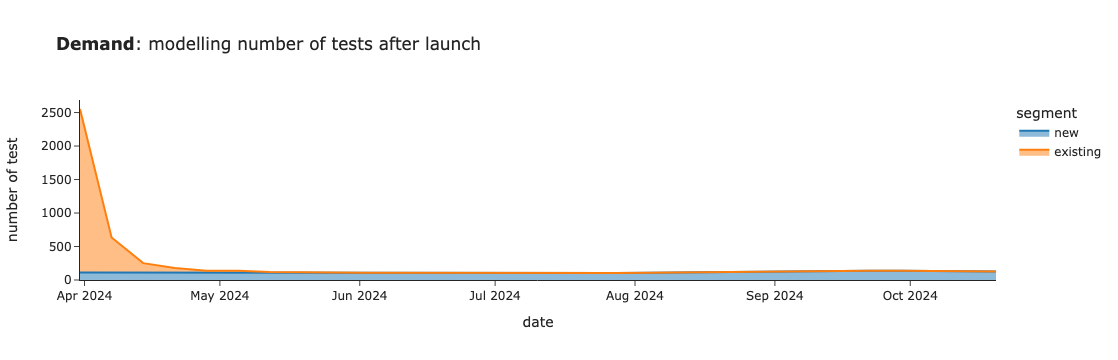

In [37]:
px.area(demand_model_df.pivot(index = 'date', columns = 'segment', values = 'users').head(30)[['new', 'existing']], 
    title = '<b>Demand</b>: modelling number of tests after launch',
    labels = {'value': 'number of tests'})

### What if we don't have enough capacity

In [38]:
raw_demand_est_model_df = new_model_df

In [39]:
capacity = 1000
demand_est_model_df = raw_demand_est_model_df.pivot(index = 'date', columns = 'segment', values = 'users')
demand_est_model_df['total_demand'] = demand_est_model_df.sum(axis = 1)
demand_est_model_df['capacity'] = capacity
demand_est_model_df['remaining_capacity'] = demand_est_model_df.capacity - demand_est_model_df.total_demand

demand_est_model_df.head()

segment     new  total_demand  capacity  remaining_capacity
date                                                       
2024-03-31  112           112      1000                 888
2024-04-07  111           111      1000                 889
2024-04-14  111           111      1000                 889
2024-04-21  112           112      1000                 888
2024-04-28  114           114      1000                 886

In [40]:
import plotly.graph_objects as go

def get_total_demand_model(raw_demand_est_model_df, capacity = 1000):
    demand_est_model_df = raw_demand_est_model_df.pivot(index = 'date', columns = 'segment', values = 'users')
    demand_est_model_df['total_demand'] = demand_est_model_df.sum(axis = 1)
    demand_est_model_df['capacity'] = capacity
    demand_est_model_df['remaining_capacity'] = demand_est_model_df.capacity - demand_est_model_df.total_demand

    tmp_df = demand_est_model_df.drop(['total_demand', 'capacity', 'remaining_capacity'], axis = 1)
    fig = px.area(tmp_df,
                 title = '<b>Demand vs Capacity</b>',
                  category_orders={'segment': ['new'] + list(sorted(filter(lambda x: x != 'new', tmp_df.columns)))},
                 labels = {'value': 'tests'})
    fig.add_trace(go.Scatter(
        x=demand_est_model_df.index, y=demand_est_model_df.capacity, 
        name='capacity', line=dict(color='black', dash='dash'))
    )
    
    fig.show()
    return demand_est_model_df

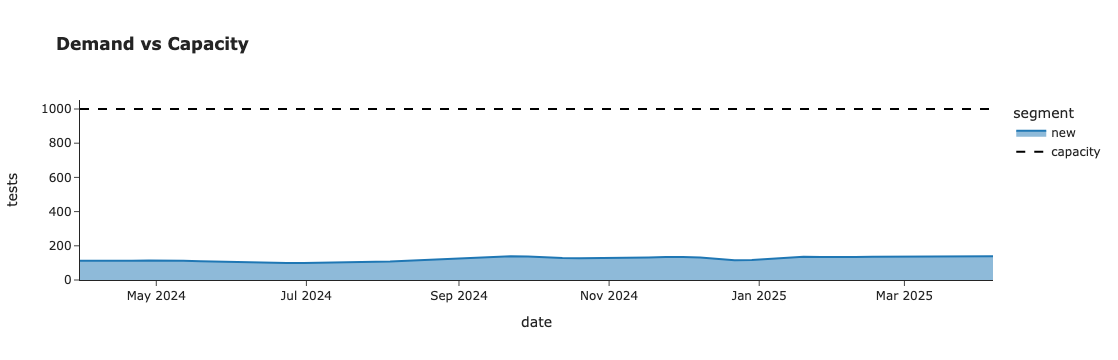

segment     new  total_demand  capacity  remaining_capacity
date                                                       
2024-03-31  112           112      1000                 888
2024-04-07  111           111      1000                 889
2024-04-14  111           111      1000                 889
2024-04-21  112           112      1000                 888
2024-04-28  114           114      1000                 886

In [41]:
demand_plan_df = get_total_demand_model(raw_demand_est_model_df)
demand_plan_df.head()

In [42]:
existing_processed = 0

In [43]:
existing_model_df['num_week'] = list(range(existing_model_df.shape[0]))
existing_model_df = existing_model_df.set_index('num_week').drop(['date', 'segment'], axis = 1)

In [44]:
existing_model_df.head()

users
num_week       
0          2441
1           523
2           141
3            67
4            25

In [45]:
existing_model_df.iloc[0].users

2441

In [46]:
rollout_plan = []

In [47]:
import math
cohort = '2024-03-31'
demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users

0.3637853338795576

In [48]:
next_group_share = demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users
next_group_share = math.floor(20*next_group_share)/20
next_group_share

0.35

In [49]:
next_group_share = math.floor(20*demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users)/20
if next_group_share > 1 - existing_processed:
    print('exceeded')
    next_group_share = round(1 - existing_processed, 1)
existing_processed += next_group_share
print(next_group_share, existing_processed)
rollout_plan.append(
    {'cohort': cohort, 'rollout': next_group_share}
)

next_group_demand_df = existing_model_df.copy().reset_index()

next_group_demand_df['date'] = next_group_demand_df.num_week.map(
    lambda x: (datetime.datetime.strptime(cohort, '%Y-%m-%d') + datetime.timedelta(7*x))
)

next_group_demand_df['users'] = (next_group_demand_df.users * next_group_share).map(lambda x: int(round(x)))

next_group_demand_df['segment'] = 'existing, cohort = %s' % cohort

raw_demand_est_model_df = pd.concat([raw_demand_est_model_df, next_group_demand_df.drop('num_week', axis = 1)])

0.35 0.35


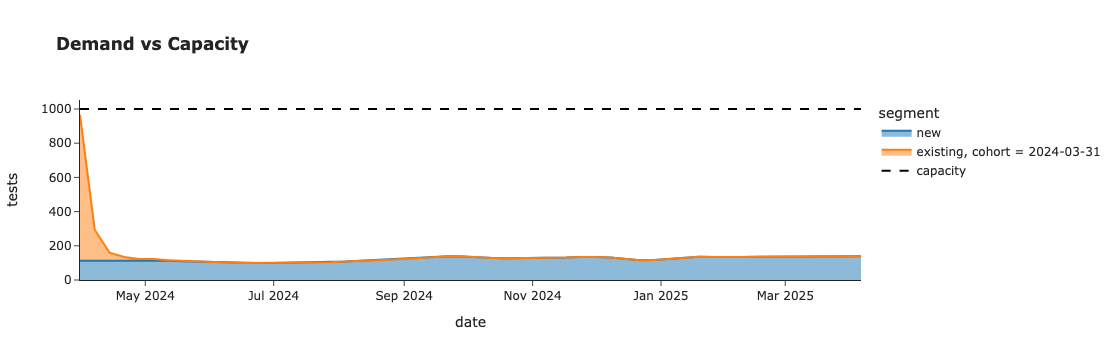

/var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/ipykernel_49987/199484237.py:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



segment     existing, cohort = 2024-03-31  new  total_demand  capacity  \
date                                                                     
2024-03-31                            854  112           966      1000   
2024-04-07                            183  111           294      1000   
2024-04-14                             49  111           160      1000   
2024-04-21                             23  112           135      1000   
2024-04-28                              9  114           123      1000   

segment     remaining_capacity  
date                            
2024-03-31                  34  
2024-04-07                 706  
2024-04-14                 840  
2024-04-21                 865  
2024-04-28                 877

In [50]:
demand_plan_df = get_total_demand_model(raw_demand_est_model_df)
demand_plan_df.head().applymap(int)

In [51]:
cohort = '2024-04-07'

In [52]:
next_group_share = math.floor(20*demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users - 1)/20
if next_group_share > 1 - existing_processed:
    print('exceeded')
    next_group_share = round(1 - existing_processed, 1)
existing_processed += next_group_share
print(next_group_share, existing_processed)
rollout_plan.append(
    {'cohort': cohort, 'rollout': next_group_share}
)

next_group_demand_df = existing_model_df.copy().reset_index()

next_group_demand_df['date'] = next_group_demand_df.num_week.map(
    lambda x: (datetime.datetime.strptime(cohort, '%Y-%m-%d') + datetime.timedelta(7*x))
)

next_group_demand_df['users'] = (next_group_demand_df.users * next_group_share).map(lambda x: int(round(x)))

next_group_demand_df['segment'] = 'existing, cohort = %s' % cohort

raw_demand_est_model_df = pd.concat([raw_demand_est_model_df, next_group_demand_df.drop('num_week', axis = 1)])

0.2 0.55


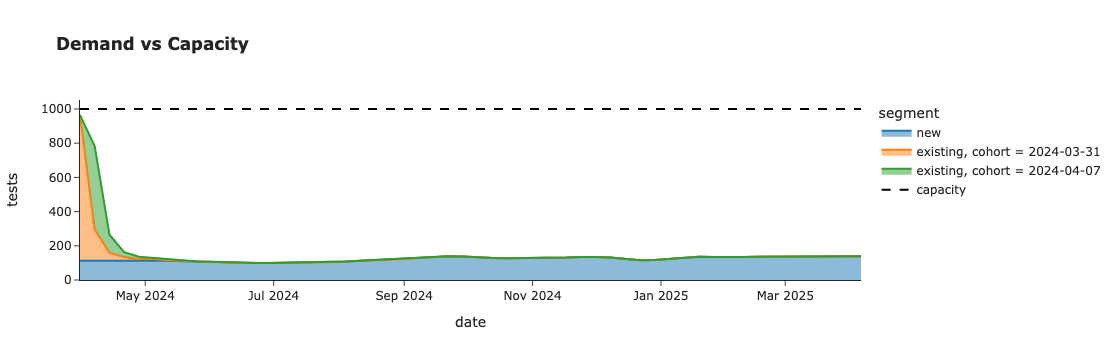

segment     existing, cohort = 2024-03-31  existing, cohort = 2024-04-07  \
date                                                                       
2024-03-31                          854.0                            NaN   
2024-04-07                          183.0                          488.0   
2024-04-14                           49.0                          105.0   
2024-04-21                           23.0                           28.0   
2024-04-28                            9.0                           13.0   

segment       new  total_demand  capacity  remaining_capacity  
date                                                           
2024-03-31  112.0         966.0      1000                34.0  
2024-04-07  111.0         782.0      1000               218.0  
2024-04-14  111.0         265.0      1000               735.0  
2024-04-21  112.0         163.0      1000               837.0  
2024-04-28  114.0         136.0      1000               864.0

In [53]:
demand_plan_df = get_total_demand_model(raw_demand_est_model_df)
demand_plan_df.head()

In [54]:
cohort = '2024-04-14'

In [55]:
next_group_share = math.floor(20*demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users - 1)/20
if next_group_share > 1 - existing_processed:
    print('exceeded')
    next_group_share = round(1 - existing_processed, 1)
existing_processed += next_group_share
print(next_group_share, existing_processed)
rollout_plan.append(
    {'cohort': cohort, 'rollout': next_group_share}
)

next_group_demand_df = existing_model_df.copy().reset_index()

next_group_demand_df['date'] = next_group_demand_df.num_week.map(
    lambda x: (datetime.datetime.strptime(cohort, '%Y-%m-%d') + datetime.timedelta(7*x))
)

next_group_demand_df['users'] = (next_group_demand_df.users * next_group_share).map(lambda x: int(round(x)))

next_group_demand_df['segment'] = 'existing, cohort = %s' % cohort

raw_demand_est_model_df = pd.concat([raw_demand_est_model_df, next_group_demand_df.drop('num_week', axis = 1)])

0.25 0.8


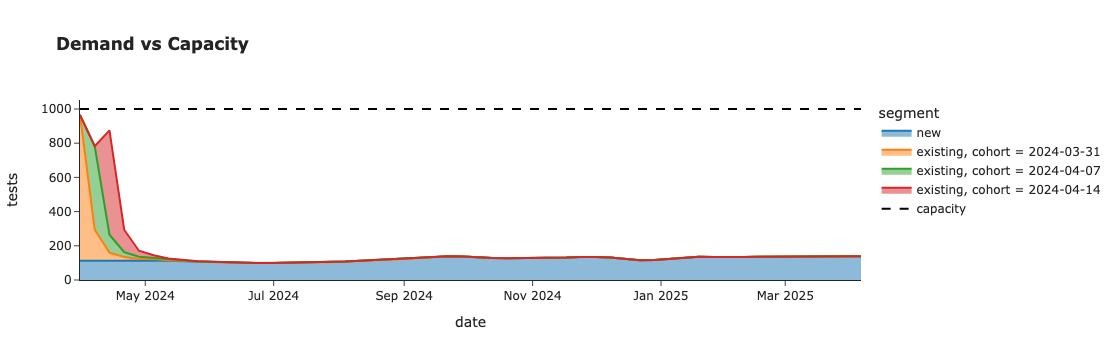

segment     existing, cohort = 2024-03-31  existing, cohort = 2024-04-07  \
date                                                                       
2024-03-31                          854.0                            NaN   
2024-04-07                          183.0                          488.0   
2024-04-14                           49.0                          105.0   
2024-04-21                           23.0                           28.0   
2024-04-28                            9.0                           13.0   

segment     existing, cohort = 2024-04-14    new  total_demand  capacity  \
date                                                                       
2024-03-31                            NaN  112.0         966.0      1000   
2024-04-07                            NaN  111.0         782.0      1000   
2024-04-14                          610.0  111.0         875.0      1000   
2024-04-21                          131.0  112.0         294.0      1000   
2024-04-28                           35.0  114.0         171.0      1000   

segment     remaining_capacity  
date                            
2024-03-31                34.0  
2024-04-07               218.0  
2024-04-14               125.0  
2024-04-21               706.0  
2024-04-28               829.0

In [56]:
demand_plan_df = get_total_demand_model(raw_demand_est_model_df)
demand_plan_df.head()

In [57]:
cohort = '2024-04-21'

In [58]:
next_group_share = math.floor(20*demand_plan_df.loc[cohort].remaining_capacity/existing_model_df.iloc[0].users - 1)/20
if next_group_share > 1 - existing_processed:
    print('exceeded')
    next_group_share = round(1 - existing_processed, 1)
existing_processed += next_group_share
print(next_group_share, existing_processed)
rollout_plan.append(
    {'cohort': cohort, 'rollout': next_group_share}
)

next_group_demand_df = existing_model_df.copy().reset_index()

next_group_demand_df['date'] = next_group_demand_df.num_week.map(
    lambda x: (datetime.datetime.strptime(cohort, '%Y-%m-%d') + datetime.timedelta(7*x))
)

next_group_demand_df['users'] = (next_group_demand_df.users * next_group_share).map(lambda x: int(round(x)))

next_group_demand_df['segment'] = 'existing, cohort = %s' % cohort

raw_demand_est_model_df = pd.concat([raw_demand_est_model_df, next_group_demand_df.drop('num_week', axis = 1)])

exceeded
0.2 1.0


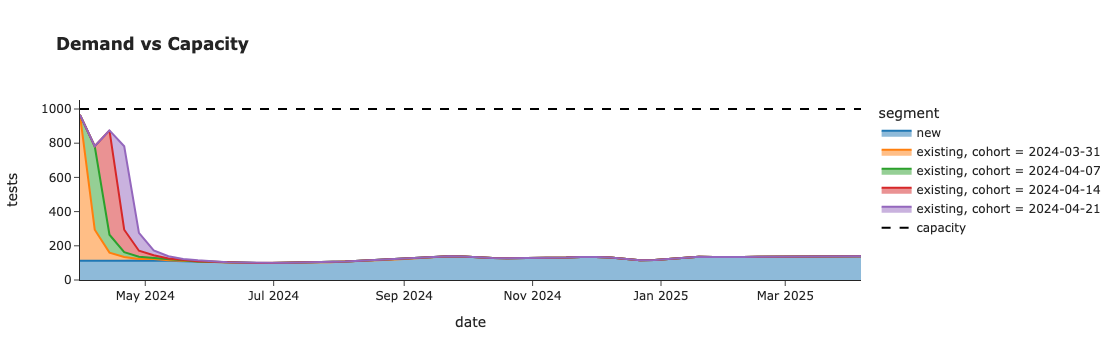

segment     existing, cohort = 2024-03-31  existing, cohort = 2024-04-07  \
date                                                                       
2024-03-31                          854.0                            NaN   
2024-04-07                          183.0                          488.0   
2024-04-14                           49.0                          105.0   
2024-04-21                           23.0                           28.0   
2024-04-28                            9.0                           13.0   

segment     existing, cohort = 2024-04-14  existing, cohort = 2024-04-21  \
date                                                                       
2024-03-31                            NaN                            NaN   
2024-04-07                            NaN                            NaN   
2024-04-14                          610.0                            NaN   
2024-04-21                          131.0                          488.0   
2024-04-28                           35.0                          105.0   

segment       new  total_demand  capacity  remaining_capacity  
date                                                           
2024-03-31  112.0         966.0      1000                34.0  
2024-04-07  111.0         782.0      1000               218.0  
2024-04-14  111.0         875.0      1000               125.0  
2024-04-21  112.0         782.0      1000               218.0  
2024-04-28  114.0         276.0      1000               724.0

In [59]:
demand_plan_df = get_total_demand_model(raw_demand_est_model_df)
demand_plan_df.head()

In [60]:
rollout_plan

[{'cohort': '2024-03-31', 'rollout': 0.35},
 {'cohort': '2024-04-07', 'rollout': 0.2},
 {'cohort': '2024-04-14', 'rollout': 0.25},
 {'cohort': '2024-04-21', 'rollout': 0.2}]

### Modelling follow-up

In [89]:
raw_existing_df.head()

user_id        date  module  lesson_num
0        1  2021-01-03  pre-A1           2
1        1  2021-01-10  pre-A1           3
2        1  2021-01-17  pre-A1           4
3        1  2021-01-24  pre-A1           5
4        1  2021-01-24  pre-A1           6

In [93]:
sim_raw_df = df[df.date >= '2023-03-31']

In [91]:
def days_diff(date1, date2):
    return (datetime.datetime.strptime(date2, '%Y-%m-%d') - datetime.datetime.strptime(date1, '%Y-%m-%d')).days

In [94]:
user_id = 4861
user_events = sim_raw_df[sim_raw_df.user_id == user_id].to_dict('records')
user_events

[{'user_id': 4861, 'date': '2023-04-09', 'module': 'pre-A1', 'lesson_num': 8},
 {'user_id': 4861, 'date': '2023-04-16', 'module': 'pre-A1', 'lesson_num': 9},
 {'user_id': 4861, 'date': '2023-04-23', 'module': 'pre-A1', 'lesson_num': 10},
 {'user_id': 4861, 'date': '2023-04-23', 'module': 'pre-A1', 'lesson_num': 11},
 {'user_id': 4861, 'date': '2023-04-30', 'module': 'pre-A1', 'lesson_num': 12},
 {'user_id': 4861, 'date': '2023-05-07', 'module': 'pre-A1', 'lesson_num': 13}]

In [95]:
import tqdm
tmp_gen_tests = []

for user_id in tqdm.tqdm(sim_raw_df.user_id.unique()):
    # initialising variables
    last_test_date = None
    last_lesson_date = None

    for rec in sim_raw_df[sim_raw_df.user_id == user_id].to_dict('records'):
        # initial test
        if last_test_date is None: 
            last_test_date = rec['date']
            tmp_gen_tests.append(
                {
                    'user_id': rec['user_id'],
                    'date': rec['date'],
                    'trigger': 'initial test'
                }
            )
        # finish module
        elif (rec['lesson_num'] == 100) and (days_diff(last_test_date, rec['date']) >= 30): 
            last_test_date = rec['date']
            tmp_gen_tests.append(
                {
                    'user_id': rec['user_id'],
                    'date': rec['date'],
                    'trigger': 'finished module'
                })
        # reactivation
        elif (days_diff(last_lesson_date, rec['date']) >= 92):
            last_test_date = rec['date']
            tmp_gen_tests.append(
                {
                    'user_id': rec['user_id'],
                    'date': rec['date'],
                    'trigger': 'reactivation'
                })
        last_lesson_date = rec['date']

100%|████████████████████████████████████████████████████████████████| 6373/6373 [00:03<00:00, 2082.15it/s]


In [96]:
exist_model_upd = pd.DataFrame(tmp_gen_tests)

In [97]:
exist_model_upd_stats_df = exist_model_upd.pivot_table(
    index = 'date', columns = 'trigger', values = 'user_id', aggfunc = 'nunique'
)

In [98]:
exist_model_upd_stats_df = exist_model_upd.pivot_table(
    index = 'date', columns = 'trigger', values = 'user_id', 
    aggfunc = 'nunique'
).fillna(0)

exist_model_upd_stats_df = exist_model_upd_stats_df.map(lambda x: int(round(x * 1.8)))

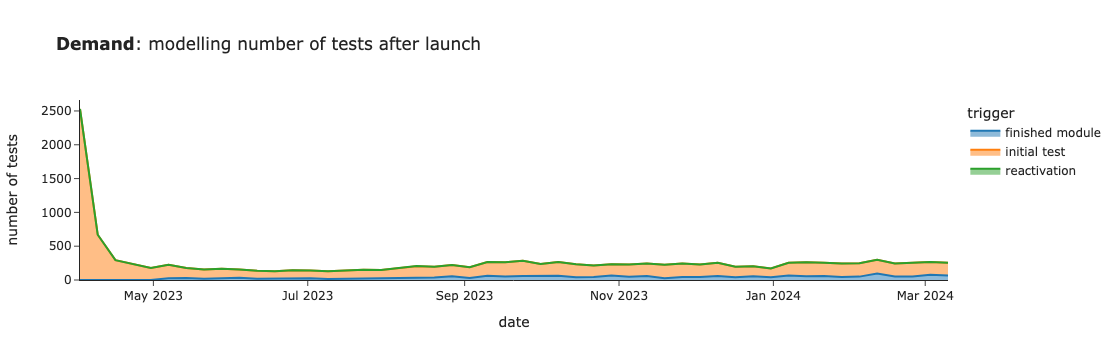

In [102]:
px.area(exist_model_upd_stats_df, 
       title = '<b>Demand</b>: modelling number of tests after launch',
    labels = {'value': 'number of tests'}
       )

In [103]:
exist_model_upd_stats_df.loc['2023-05-07':].quantile(0.25)

trigger
finished module     27.0
initial test       144.0
reactivation         0.0
Name: 0.25, dtype: float64

In [104]:
exist_model_upd_stats_df.loc['2023-05-07':].quantile(0.75)

trigger
finished module     58.0
initial test       198.0
reactivation         0.0
Name: 0.75, dtype: float64